In [1]:
import glob, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import glob
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import ast
fft_size = 16777216
time_res = 64e-6 # in seconds
T_obs = (fft_size*time_res)/60 # in minutes is equal to 17.895 minutes
freq_axis = np.fft.rfftfreq(fft_size, d=64e-6)
freq_res = 1/(T_obs*60)

2023-06-19 18:30:35.503395: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
cur_dir = ''
run = 'runBB'
X_train = np.load(cur_dir + f'raw_data/{run}/train_data_chunk.npy').astype(np.float64)
X_test = np.load(cur_dir + f'raw_data/{run}/test_data_chunk.npy').astype(np.float64)
X_val = np.load(cur_dir + f'raw_data/{run}/val_data_chunk.npy').astype(np.float64)
X_train = X_train/np.max(X_train,axis=1)[:,None]
X_test = X_test/np.max(X_test,axis=1)[:,None]
X_val = X_val/np.max(X_val,axis=1)[:,None]

Y_train = np.load(cur_dir + f'raw_data/{run}/train_labels_chunk.npy').astype(np.float64)
Y_test = np.load(cur_dir + f'raw_data/{run}/test_labels_chunk.npy').astype(np.float64)
Y_val = np.load(cur_dir + f'raw_data/{run}/val_labels_chunk.npy').astype(np.float64)


# z_val = Y_val[:,1].copy()
# Y_val[:,0] = Y_val[:,0] - z_val
# Y_val[:,1] = Y_val[:,0] + z_val
# Y_val = np.sort(Y_val,axis=1)

# z_test = Y_test[:,1].copy()
# Y_test[:,0] = Y_test[:,0] - z_test
# Y_test[:,1] = Y_test[:,0] + z_test
# Y_test = np.sort(Y_test,axis=1)

# z_train = Y_train[:,1].copy()
# Y_train[:,0] = Y_train[:,0] - z_train
# Y_train[:,1] = Y_train[:,0] + z_train
# Y_train = np.sort(Y_train,axis=1)

Y_train[:,0] = np.abs(Y_train[:,0])
Y_test[:,0] = np.abs(Y_test[:,0])
Y_val[:,0] = np.abs(Y_val[:,0])

Y_train[:,1] = 2*np.abs(Y_train[:,1])
Y_test[:,1] = 2*np.abs(Y_test[:,1])
Y_val[:,1] = 2*np.abs(Y_val[:,1])

# Y_train = 2*np.abs(Y_train[:,1])
# Y_test = 2*np.abs(Y_test[:,1])
# Y_val = 2*np.abs(Y_val[:,1])

# # Y_train = Y_train/400
# # Y_test = Y_test/400
# # Y_val = Y_val/400

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1) 

Y_train = (Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1))
Y_val = (Y_val.reshape(Y_val.shape[0],Y_val.shape[1], 1))
Y_test = (Y_test.reshape(Y_test.shape[0],Y_test.shape[1], 1))

# Y_train = (Y_train.reshape(Y_train.shape[0],1))
# Y_val = (Y_val.reshape(Y_val.shape[0],1))
# Y_test = (Y_test.reshape(Y_test.shape[0],1))


In [2]:
cur_dir = ''
run = 'runBB'
test_indices = np.load(cur_dir + f'raw_data/{run}/test_indices.npy')
labels_df = pd.read_csv(cur_dir + f'meta_data/labels_{run}.csv')

In [3]:
dat_file_pn = glob.glob('/hercules/scratch/atya/PulsarNet/output/*.txt')

In [4]:
len(dat_file_pn)

400

In [5]:
pattern = r'obs(\d+)BB_predictions\.txt'
for i in range(len(dat_file_pn)):
    with open(dat_file_pn[i]) as f:
        match = re.search(pattern, dat_file_pn[i])
        if match:
            index = match.group(1)
            print(index)
            lines = f.readlines()
            p_middle_pred_pulsar_net = float(lines[0].split(':')[1][1:-1])/1000
            sign = lines[6].split(':')[1][1:-1][0]
            if sign == 'pos':
                factor = 1
                p_fold_pred_pulsar_net = float(lines[3].split(':')[1][1:-1][1:])/1000
            else:
                factor = -1
                p_fold_pred_pulsar_net = float(lines[4].split(':')[1][1:-1])/1000
            a_pred_pulsar_net = factor*float(lines[1].split(':')[1][1:-1])
            pd_pred_pulsar_net = factor*float(lines[2].split(':')[1][1:-1])
            fold_snr_pred_pulsar_net = np.max(ast.literal_eval(lines[5].split(':')[1][1:-1]))
            labels_df.loc[int(index),'p_middle_pred_pulsar_net'] = p_middle_pred_pulsar_net
            labels_df.loc[int(index),'p_fold_pred_pulsar_net'] = p_fold_pred_pulsar_net
            labels_df.loc[int(index),'a_pred_pulsar_net'] = a_pred_pulsar_net
            labels_df.loc[int(index),'pd_pred_pulsar_net'] = pd_pred_pulsar_net
            labels_df.loc[int(index),'fold_snr_pred_pulsar_net'] = fold_snr_pred_pulsar_net

638
278
456
1069
1248
680
525
1959
12
1140
1010
1210
920
105
100
683
1515
1890
1125
264
1982
530
1270
838
662
1791
429
1562
1809
1076
388
74
1921
1646
223
1370
48
1228
1124
1189
1860
1056
413
210
1094
120
1
1878
805
1209
1229
1156
1360
281
1356
1650
152
1456
1300
934
837
539
922
554
1368
1738
707
791
131
1843
1937
1669
1774
349
694
1736
635
204
1442
84
1154
676
562
1734
1530
346
431
984
1278
1848
1780
780
1757
1661
87
92
547
203
127
1274
291
1383
993
138
378
1988
1506
189
946
10
1749
385
1792
973
1975
785
1728
1796
1936
1092
322
1046
799
679
850
1495
1093
1107
487
1408
1259
221
66
149
1019
1771
1567
953
511
648
1756
1437
414
1946
891
1737
794
1758
1222
958
1225
825
1173
592
1487
1759
775
1161
549
1645
1015
1483
29
1709
46
801
1386
632
829
1690
510
218
1017
1247
1510
373
1064
1853
1469
1917
1541
406
590
1234
1597
1005
1223
1421
764
1787
259
982
1249
1657
182
33
1232
1422
146
81
136
913
904
1255
1182
121
1294
1200
1772
1747
893
622
1590
339
272
758
8
823
1859
1242
890
1103
1137
79
1074
1

In [6]:
labels_df.columns

Index(['# ind', 'period', 'snr', 'width', 'bper', 'binc', 'bcmass', 'bphase',
       'status', 'a', 'p_middle', 'pd', 'z', 'a_max', 'z_max', 'p_fold',
       'file_name', 'asini', 'periastron_time_mjd', 'fold_snr_theory',
       'fold_snr_true', 'p_true', 'pd_true', 'fold_snr_presto', 'p_presto',
       'pd_presto', 'chunk_start', 'p_pred', 'z_pred', 'a_pred', 'pd_pred',
       'p_fold_pred', 'fold_snr_pred', 'p_pred_from_bestprof',
       'pd_pred_from_bestprof', 'p_middle_pred_pulsar_net',
       'p_fold_pred_pulsar_net', 'a_pred_pulsar_net', 'pd_pred_pulsar_net',
       'fold_snr_pred_pulsar_net'],
      dtype='object')

In [ ]:
labels_df.to_csv(cur_dir + f'meta_data/labels_runBB.csv',index=False)

In [12]:
labels_df_fil[np.abs(labels_df_fil['p_middle_pred_pulsar_net']-labels_df_fil['p_middle'])>0.0000003]['# ind'].values

array([970.])

In [15]:
np.median(1 - labels_df_fil['fold_snr_true']/labels_df_fil['fold_snr_theory'])

0.028274046022694177

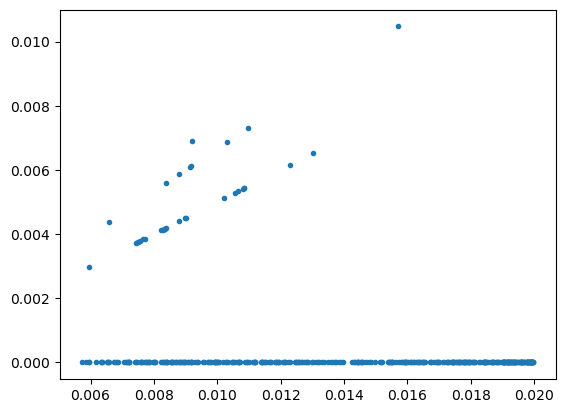

In [23]:
labels_df_fil = labels_df[labels_df['p_middle_pred_pulsar_net'].isna() == False]
plt.plot(labels_df_fil['p_middle'],np.abs(labels_df_fil['p_middle_pred_pulsar_net']-labels_df_fil['p_middle']),'.')

In [21]:
np.median(np.abs(labels_df_fil['p_middle_pred_pulsar_net']-labels_df_fil['p_middle'])*100/labels_df_fil['p_middle'])

0.00023944496294323465

In [13]:
def period_accuracy(Y_test, Y_pred):
    """
    Computes the percentage of predicted periods that are within 0.5% of the true periods.
    """
    accuracies = []
    Y_test = tf.cast(Y_test, tf.float32)
    Y_pred = tf.cast(Y_pred, tf.float32)
    shape = Y_test.shape[1]
    for i in range(shape):
        rat = (Y_test[:,i]+ 1e-10)/(Y_pred[:,i]+ 1e-10)
        rat_bool = tf.logical_and(tf.less(rat, 1.005), tf.greater(rat, 0.995))
        accuracy = tf.reduce_mean(tf.cast(rat_bool, tf.float32)) * 100
        accuracies.append(accuracy)
    return [acc.numpy() for acc in accuracies]


def median_percent_deviation(Y_test, Y_pred):
    """
    Computes the median percent deviation from the predicted period.
    """
    Y_test = tf.cast(Y_test, tf.float32)
    Y_pred = tf.cast(Y_pred, tf.float32)
    median_deviations = []
    shape = Y_test.shape[1]
    for i in range(shape):
        
        Y_test_i = Y_test[:,i]
        Y_pred_i = Y_pred[:,i]

        percent_deviation = tf.abs((Y_test_i - Y_pred_i) / (Y_test_i + 1e-10)) * 100
        median_deviation = tfp.stats.percentile(percent_deviation, q=50)
        median_deviations.append(median_deviation)

    return [med.numpy() for med in median_deviations]


In [14]:
cur_dir = ''

In [15]:
# Load the best model after training
best_modelf = tf.keras.models.load_model('models/f_predict_cnn_1280525_checkpoint.h5')
best_modelz = tf.keras.models.load_model('models/f_predict_attention_z_fine_1231538_55_checkpoint.h5')
# best_modelf = tf.keras.models.load_model("models/f_predict_cnn_1231547_checkpoint.h5")
# best_modelz = tf.keras.models.load_model("models/f_predict_attention_z_fine_1231538_55_checkpoint.h5")

In [16]:
z_pred = best_modelz.predict(X_test)
f_pred = best_modelf.predict(X_test)

In [17]:
period_accuracy(z_pred,Y_test[:,1])

[75.75]

In [18]:
period_accuracy(f_pred,Y_test[:,0])

[96.5]

In [19]:
Y_pred = np.concatenate((f_pred,z_pred),axis=1)

In [23]:
z_pred

array([[  2.346244  ],
       [ 21.831303  ],
       [ 73.86885   ],
       [ 22.573437  ],
       [ 58.916306  ],
       [ 72.95821   ],
       [ 93.147675  ],
       [  0.43649027],
       [ 76.98518   ],
       [ 92.98492   ],
       [ 66.247986  ],
       [ 18.892904  ],
       [ 85.70945   ],
       [ 36.422543  ],
       [ 35.579857  ],
       [ 73.11      ],
       [ 50.83228   ],
       [ 17.285973  ],
       [  7.0758505 ],
       [ 10.453688  ],
       [ 76.15161   ],
       [ 87.91741   ],
       [ 86.70537   ],
       [ 75.27574   ],
       [ 93.175896  ],
       [ 77.82922   ],
       [ 50.547516  ],
       [ 65.00954   ],
       [ 22.291388  ],
       [  0.80446684],
       [  9.118367  ],
       [ 57.53683   ],
       [ 56.422176  ],
       [ 20.916328  ],
       [ 23.163755  ],
       [ 79.76567   ],
       [ 92.909386  ],
       [ 32.382797  ],
       [ 17.728731  ],
       [ 77.219345  ],
       [100.36971   ],
       [ 20.576239  ],
       [ 63.7348    ],
       [ 25

In [22]:
f_pred

array([[113.93114 ],
       [369.79977 ],
       [317.20255 ],
       [127.9625  ],
       [111.00576 ],
       [234.65967 ],
       [ 77.28581 ],
       [112.88114 ],
       [169.80591 ],
       [270.49225 ],
       [131.1998  ],
       [119.25461 ],
       [204.12848 ],
       [158.7643  ],
       [176.60323 ],
       [304.01694 ],
       [329.3143  ],
       [209.74928 ],
       [289.7905  ],
       [175.96622 ],
       [ 69.75339 ],
       [305.90695 ],
       [289.1745  ],
       [ 95.79854 ],
       [115.25786 ],
       [218.13965 ],
       [223.11572 ],
       [312.66174 ],
       [210.30428 ],
       [184.8158  ],
       [ 64.78567 ],
       [ 93.762955],
       [281.223   ],
       [340.28284 ],
       [152.6491  ],
       [184.49687 ],
       [ 77.17517 ],
       [355.2573  ],
       [185.17386 ],
       [321.91922 ],
       [148.63083 ],
       [336.231   ],
       [ 55.547478],
       [263.84924 ],
       [281.72662 ],
       [ 85.311104],
       [366.0388  ],
       [145.9

In [27]:
Y_pred = Y_pred.reshape(Y_test.shape)

In [26]:
Y_test.shape

(400, 2, 1)

In [28]:
accuracy = period_accuracy(Y_test, Y_pred)
median = median_percent_deviation(Y_test, Y_pred)
print("Period accuracy: ", accuracy)
print("Median percent deviation: ", median)

Period accuracy:  [96.5, 75.75]
Median percent deviation:  [0.07643606, 0.2169023]


In [ ]:
for i in range(len(test_indices)):
    plt.plot(X_test[i])
    plt.axvline(x=Y_test[i,0],color='r')
    plt.axvline(x=Y_pred[i,0],color='g')
    plt.show()
    plt.close()

In [37]:
for i in range(Y_test.shape[0]):
    ind = test_indices[i]
    chunk_index = labels_df.loc[ind,'chunk_start']
    freq = chunk_index + Y_pred[i,0]
    #freq2 = chunk_index + Y_test[i,1]
    labels_df.at[ind,'p_pred'] = 1/(freq*freq_res)
    # if freq1 < freq2:
    #     labels_df.at[ind,'pred_freq_index0'] = freq1
    #     labels_df.at[ind,'pred_freq_index1'] = freq2

In [38]:
for i in range(Y_test.shape[0]):
    ind = test_indices[i]
    z = labels_df.loc[ind,'z']
    if z > 0:
       labels_df.at[ind,'z_pred'] = Y_pred[i,1]/2
    else:
        labels_df.at[ind,'z_pred'] = -Y_pred[i,1]/2 


In [40]:
labels_df_filtered = labels_df[~labels_df['p_pred'].isna()]

0.06282209544157902


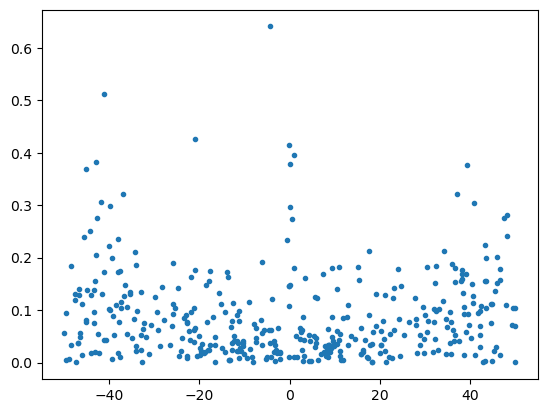

In [43]:
plt.plot(labels_df_filtered['z'],np.abs(labels_df_filtered['z_pred'] - labels_df_filtered['z']),'.')
print(np.median(np.abs(labels_df_filtered['z_pred'] - labels_df_filtered['z'])))

3.86545332435248e-08


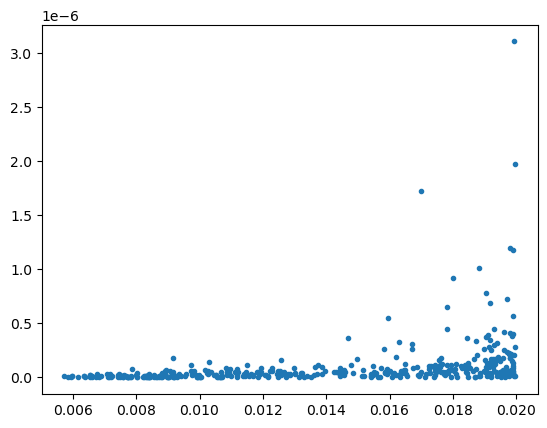

In [46]:
plt.plot(labels_df_filtered['period'],np.abs(labels_df_filtered['p_middle'] - labels_df_filtered['p_pred']),'.')
print(np.median(np.abs(labels_df_filtered['p_middle'] - labels_df_filtered['p_pred'])))

In [47]:
labels_df.to_csv('meta_data/labels_runBB.csv',index=False)

In [5]:
run = 'runBB'
files_list_temp = glob.glob(f'/hercules/results/atya/BinaryML/sims/{run}/fold_output_pred/*pfd.bestprof')
list_dicts_temp = []

for i in range(len(files_list_temp)):
    file = files_list_temp[i]
    with open(file, 'r') as file:
        data_dict = {}
        for line in file:
            # Remove any new line characters
            line = line.strip()

            # Skip empty lines or comment lines
            if not line:
                continue
            if '###############################' in line:
                break
            # Split the line by the '=' character

            key,value = re.split('=|>|<', line)

            #key, value = line.split('=|>|<')

            # Remove any leading or trailing whitespace
            key = key.strip()[2:]
            value = value.strip()

            # Add the key-value pair to the dictionary
            data_dict[key] = value
        list_dicts_temp.append(data_dict)

In [6]:
for item in list_dicts_temp:
    temp = item['Prob(Noise)']
    temp_list = temp.split(' ')
    item['prob'] = float(temp_list[0])
    item['noise'] = float(temp_list[3][2:])
    temp_p = item['P_topo (ms)']
    item['p_presto']= float(temp_p.split('+/-')[0])
    temp_pd = item["P'_topo (s/s)"]
    item['pd_presto'] = float(temp_pd.split('+/-')[0])

In [7]:
for dic in list_dicts_temp:
    file_name = dic['Input file']
    if file_name in labels_df['file_name'].values:
        labels_df.loc[labels_df['file_name']==file_name,'fold_snr_pred'] = dic['noise']
        labels_df.loc[labels_df['file_name']==file_name,'p_pred_from_bestprof'] = dic['p_presto']/1000
        labels_df.loc[labels_df['file_name']==file_name,'pd_pred_from_bestprof'] = dic['pd_presto']

In [8]:
labels_df.to_csv('meta_data/labels_runBB.csv',index=False)

In [10]:
labels_df.columns

Index(['# ind', 'period', 'snr', 'width', 'bper', 'binc', 'bcmass', 'bphase',
       'status', 'a', 'p_middle', 'pd', 'z', 'a_max', 'z_max', 'p_fold',
       'file_name', 'asini', 'periastron_time_mjd', 'fold_snr_theory',
       'fold_snr_true', 'p_true', 'pd_true', 'fold_snr_presto', 'p_presto',
       'pd_presto', 'chunk_start', 'p_pred', 'z_pred', 'a_pred', 'pd_pred',
       'p_fold_pred', 'fold_snr_pred', 'p_pred_from_bestprof',
       'pd_pred_from_bestprof'],
      dtype='object')